In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
g = torch.Generator(device='cpu').manual_seed(2147483647)

In [62]:
SEED = 42

CONTEXT_LEN = 8 # Must be a multiple of 2 for the WaveNet.

VOCAB_SIZE = 27 # 26 letters + 1 for padding
EMBED_DIMS = 24
HIDDEN_DIMS = 128

BATCH_SIZE  = 32
EPOCHS  =  200000
LEARNING_RATE = 0.1

In [63]:
words = open('names.txt').read().splitlines()

In [64]:
stoi = {s:i+1 for i, s in enumerate(sorted(set(''.join(words))))}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [65]:
def build_dataset(words):
    X, y = [], []
    for w in words:
        context = [0] * CONTEXT_LEN
        chrs = list(w) + ['.']
        for c in chrs:
            X.append(context)
            y.append(stoi[c])
            context = context[1:] + [stoi[c]]

    X = torch.tensor(X)
    y = torch.tensor(y)
    return X, y

random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, ytr = build_dataset(words[:n1])
Xv, yv = build_dataset(words[n1:n2])
Xte, yte = build_dataset(words[n2:])
# Train dataset is used to train the parameters, val is used to tune hyperparameters, and test is used to evaluate the final model.

In [66]:
for x,y in zip(Xtr[:20], ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> c
.......c --> a
......ca --> r
.....car --> n
....carn --> e
...carne --> l
..carnel --> l
.carnell --> .
........ --> m
.......m --> i
......mi --> a
.....mia --> s
....mias --> i
...miasi --> a
..miasia --> .
........ --> o
.......o --> l
......ol --> y
.....oly --> m
....olym --> p


In [67]:
assert Xtr.shape[1] == CONTEXT_LEN # N × CONTEXT_LEN
samples = Xtr.shape[0]
assert ytr.shape == (samples,)

In [68]:
# -----------------------------------------------------------------------------------------------
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            else:
                raise ValueError(f"Unsupported input dimensions: {x.ndim}. Expected 2 or 3 dimensions.")
            
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------
class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        N, T, C = x.shape
        x = x.view(N, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------
class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [69]:
model = Sequential([
    Embedding(VOCAB_SIZE, EMBED_DIMS),

    FlattenConsecutive(2),
    Linear(EMBED_DIMS * 2, HIDDEN_DIMS, bias=False),
    BatchNorm1d(HIDDEN_DIMS),
    Tanh(),

    FlattenConsecutive(2),
    Linear(HIDDEN_DIMS * 2, HIDDEN_DIMS, bias=False),
    BatchNorm1d(HIDDEN_DIMS),
    Tanh(),

    FlattenConsecutive(2),
    Linear(HIDDEN_DIMS * 2, HIDDEN_DIMS, bias=False),
    BatchNorm1d(HIDDEN_DIMS),
    Tanh(),

    Linear(HIDDEN_DIMS, VOCAB_SIZE),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

print(f'Number of parameters: {sum(p.nelement() for p in model.parameters())}')
for p in model.parameters():
    p.requires_grad = True

Number of parameters: 76579


In [70]:
for layer in model.layers:
    if isinstance(layer, BatchNorm1d):
        layer.training = True

In [71]:
lossi = []

for epoch in range(EPOCHS):
    # minibatching
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,), generator=g)
    Xb = Xtr[ix]
    yb = ytr[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, yb)

    # backward pass
    for p in model.parameters():
        p.grad = None
    loss.backward()

    # update parameters
    with torch.no_grad():
        for p in model.parameters():
            lr = LEARNING_RATE if epoch < EPOCHS//2 else LEARNING_RATE * 0.1
            p -= lr * p.grad
        
    if epoch % 10000 == 0: # print every once in a while
        print(f'{epoch:7d}/{EPOCHS:7d}: {loss.item():.4f}')

    lossi.append(loss.item())

      0/ 200000: 3.3101
  10000/ 200000: 1.7497
  20000/ 200000: 2.0786
  30000/ 200000: 1.8087
  40000/ 200000: 2.4492
  50000/ 200000: 1.8686
  60000/ 200000: 2.2886
  70000/ 200000: 1.9253
  80000/ 200000: 1.9398
  90000/ 200000: 1.9496
 100000/ 200000: 1.8602


KeyboardInterrupt: 

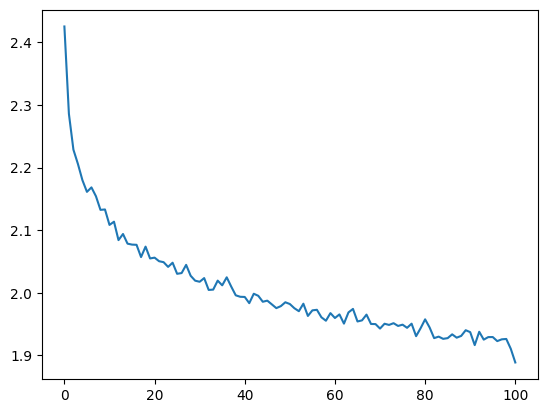

In [73]:
trim = len(lossi) // 1000 * 1000
plt.plot(torch.tensor(lossi[:trim]).view(-1, 1000).mean(1), label='Train Loss')

In [74]:
for layer in model.layers:
    print(f'{layer.__class__.__name__}: {layer.out.shape}')

Embedding: torch.Size([32, 8, 24])
FlattenConsecutive: torch.Size([32, 4, 48])
Linear: torch.Size([32, 4, 128])
BatchNorm1d: torch.Size([32, 4, 128])
Tanh: torch.Size([32, 4, 128])
FlattenConsecutive: torch.Size([32, 2, 256])
Linear: torch.Size([32, 2, 128])
BatchNorm1d: torch.Size([32, 2, 128])
Tanh: torch.Size([32, 2, 128])
FlattenConsecutive: torch.Size([32, 256])
Linear: torch.Size([32, 128])
BatchNorm1d: torch.Size([32, 128])
Tanh: torch.Size([32, 128])
Linear: torch.Size([32, 27])


In [75]:
for layer in model.layers:
    if isinstance(layer, BatchNorm1d):
        layer.training = False  # set to eval mode

In [76]:
@torch.no_grad
def evaluate_loss(X, y):
    logits = model(X)
    loss = F.cross_entropy(logits, y)
    return loss.item()

train_loss = evaluate_loss(Xtr, ytr)
val_loss = evaluate_loss(Xv, yv)
print(f'Train loss: {train_loss:.4f}')
print(f'Validation loss: {val_loss:.4f}')

Train loss: 1.8415
Validation loss: 1.9977
